In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, auc, roc_curve, precision_recall_fscore_support, accuracy_score, 
    precision_score, recall_score, f1_score)
from sklearn.base import clone

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier

In [2]:
# Load the dataset
df = pd.read_csv(r"Data/creditcard.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# check for missing values
print(df.isnull().sum().sum())

0


In [4]:
df[['Amount', 'Class']].describe().round(2)

,Amount,Class
count,284807.00,284807.00
mean,88.35,0.00
std,250.12,0.04
min,0.00,0.00
25%,5.60,0.00
50%,22.00,0.00
75%,77.16,0.00
max,25691.16,1.00


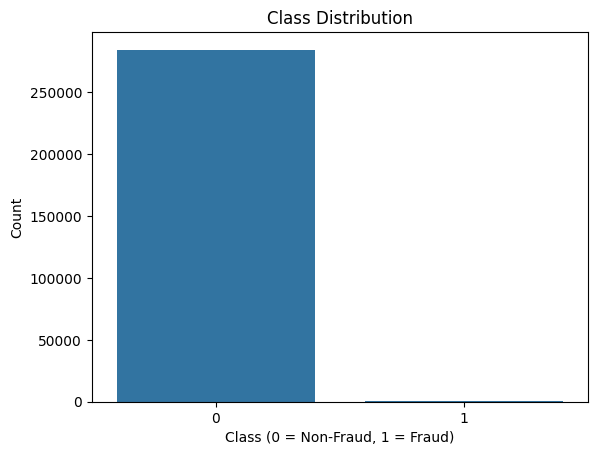

In [5]:
# Countplot for class distribution
sns.countplot(data=df, x='Class')
plt.title('Class Distribution')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='Class', ylabel='Amount'>

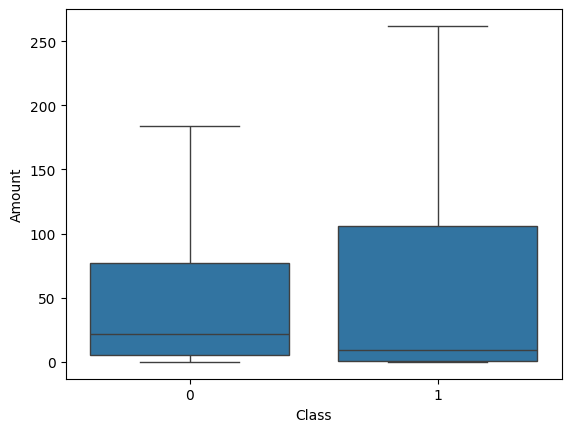

In [6]:
sns.boxplot(data=df, x='Class', y='Amount', showfliers=False)

<Axes: >

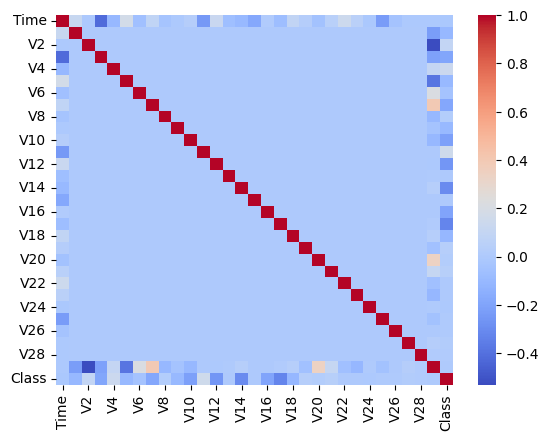

In [7]:
sns.heatmap(df.corr(), cmap='coolwarm')

<h1 style='font-weight:bold; color:orange'> Part B : Baseline Model without Resampling </h1

## ========== DATA PRE-PROCESSING ==========

In [8]:
# Feature-target split
X = df.drop("Class", axis=1)
y = df["Class"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionaries to store results and distributions
results_lr = {}
results_dt = {}
distributions = {}

# Helper function to evaluate and store results
def evaluate_model_train(name, model, x_train, y_train, x_test, y_test, results):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    
    acc = accuracy_score(y_train, y_pred)
    prec = precision_score(y_train, y_pred)
    rec = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    roc = roc_auc_score(y_train, y_pred)

    results[name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': roc
    }

    print(f"\n🔍 {name} - Training Data Evaluation:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC      : {roc:.4f}")

def evaluate_model_test(name, model, x_train, y_train, x_test, y_test, results):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)

    results[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'AUC': roc
    }

    print(f"\n🔍 {name} - Testing Data Evaluation:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC      : {roc:.4f}")    

## ========== MODEL TRAINING ==========

In [9]:
# Train baseline models (logistic regression and decision tree)
distributions['Baseline'] = y_train.value_counts().sort_index()

evaluate_model_train('Baseline', LogisticRegression(random_state=42), X_train_scaled, y_train, X_test_scaled, y_test, results_lr)
evaluate_model_train('Baseline', DecisionTreeClassifier(random_state=42), X_train_scaled, y_train, X_test_scaled, y_test, results_dt)

evaluate_model_test('Baseline', LogisticRegression(random_state=42), X_train_scaled, y_train, X_test_scaled, y_test, results_lr)
evaluate_model_test('Baseline', DecisionTreeClassifier(random_state=42), X_train_scaled, y_train, X_test_scaled, y_test, results_dt)


🔍 Baseline - Training Data Evaluation:
Accuracy : 0.9992
Precision: 0.8831
Recall   : 0.6366
F1-score : 0.7399
ROC      : 0.8182

🔍 Baseline - Training Data Evaluation:
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
ROC      : 1.0000

🔍 Baseline - Testing Data Evaluation:
Accuracy : 0.9991
Precision: 0.8505
Recall   : 0.6149
F1-score : 0.7137
ROC      : 0.8073

🔍 Baseline - Testing Data Evaluation:
Accuracy : 0.9992
Precision: 0.7786
Recall   : 0.7365
F1-score : 0.7569
ROC      : 0.8681


<h1 style='font-weight:bold; color:orange'> Part C : Addressing Imbalance </h1>

## ========== TECHNIQUES ==========

In [10]:
# 2. SMOTE
X_smote, y_smote = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)
distributions['SMOTE'] = y_smote.value_counts()
evaluate_model_test('SMOTE', LogisticRegression(random_state=42), X_smote, y_smote, X_test_scaled, y_test, results_lr)
evaluate_model_test('SMOTE', DecisionTreeClassifier(random_state=42), X_smote, y_smote, X_test_scaled, y_test, results_dt)

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1038, in


🔍 SMOTE - Testing Data Evaluation:
Accuracy : 0.9777
Precision: 0.0645
Recall   : 0.8784
F1-score : 0.1202
ROC      : 0.9281

🔍 SMOTE - Testing Data Evaluation:
Accuracy : 0.9971
Precision: 0.3408
Recall   : 0.7230
F1-score : 0.4632
ROC      : 0.8603


In [11]:
# 3. Undersampling
X_rus, y_rus = RandomUnderSampler(random_state=42).fit_resample(X_train_scaled, y_train)
distributions['Undersampling'] = y_rus.value_counts()
evaluate_model_test('Undersampling', LogisticRegression(random_state=42), X_rus, y_rus, X_test_scaled, y_test, results_lr)
evaluate_model_test('Undersampling', DecisionTreeClassifier(random_state=42), X_rus, y_rus, X_test_scaled, y_test, results_dt)


🔍 Undersampling - Testing Data Evaluation:
Accuracy : 0.9774
Precision: 0.0641
Recall   : 0.8851
F1-score : 0.1195
ROC      : 0.9313

🔍 Undersampling - Testing Data Evaluation:
Accuracy : 0.8867
Precision: 0.0135
Recall   : 0.8919
F1-score : 0.0265
ROC      : 0.8893


In [12]:
# 4. Class Weight
evaluate_model_test('Class Weight', LogisticRegression(random_state=42, class_weight='balanced'), X_train_scaled, y_train, X_test_scaled, y_test, results_lr)
evaluate_model_test('Class Weight', DecisionTreeClassifier(random_state=42, class_weight='balanced'), X_train_scaled, y_train, X_test_scaled, y_test, results_dt)
distributions['Class Weight'] = y_train.value_counts()


🔍 Class Weight - Testing Data Evaluation:
Accuracy : 0.9786
Precision: 0.0671
Recall   : 0.8784
F1-score : 0.1247
ROC      : 0.9286

🔍 Class Weight - Testing Data Evaluation:
Accuracy : 0.9991
Precision: 0.7734
Recall   : 0.6689
F1-score : 0.7174
ROC      : 0.8343


In [13]:
# 5. ADASYN
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_resample(X_train_scaled, y_train)
distributions['ADASYN'] = y_adasyn.value_counts()
evaluate_model_test('ADASYN', LogisticRegression(random_state=42), X_adasyn, y_adasyn, X_test_scaled, y_test, results_lr)
evaluate_model_test('ADASYN', DecisionTreeClassifier(random_state=42), X_adasyn, y_adasyn, X_test_scaled, y_test, results_dt)


🔍 ADASYN - Testing Data Evaluation:
Accuracy : 0.9301
Precision: 0.0220
Recall   : 0.9054
F1-score : 0.0429
ROC      : 0.9178

🔍 ADASYN - Testing Data Evaluation:
Accuracy : 0.9973
Precision: 0.3551
Recall   : 0.6622
F1-score : 0.4623
ROC      : 0.8300


In [14]:
# 6. Balanced Bagging
bb_lr = BalancedBaggingClassifier(estimator=LogisticRegression(random_state=42), random_state=42)
bb_dt = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42)
evaluate_model_test('Balanced Bagging', bb_lr, X_train_scaled, y_train, X_test_scaled, y_test, results_lr)
evaluate_model_test('Balanced Bagging', bb_dt, X_train_scaled, y_train, X_test_scaled, y_test, results_dt)
distributions['Balanced Bagging'] = y_train.value_counts()


🔍 Balanced Bagging - Testing Data Evaluation:
Accuracy : 0.9733
Precision: 0.0547
Recall   : 0.8851
F1-score : 0.1031
ROC      : 0.9293

🔍 Balanced Bagging - Testing Data Evaluation:
Accuracy : 0.9785
Precision: 0.0649
Recall   : 0.8514
F1-score : 0.1206
ROC      : 0.9150


In [15]:
# 7. Threshold Moving (Logistic Regression only)
lr_thresh = clone(LogisticRegression(random_state=42)).fit(X_train_scaled, y_train)
y_prob_thresh = lr_thresh.predict_proba(X_test_scaled)[:, 1]
threshold = 0.3
y_pred_thresh = (y_prob_thresh >= threshold).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary')
acc = np.mean(y_pred_thresh == y_test)
roc = roc_auc_score(y_test, y_prob_thresh)

results_lr['Threshold Moving'] = {
    "Accuracy": acc,
    "Precision": prec, 
    "Recall": rec, 
    "F1-score": f1,
    "AUC": roc
}
distributions['Threshold Moving'] = y_train.value_counts()

In [16]:
# build LR table
lr_table = pd.DataFrame(results_lr).T

# build DT table
dt_table = pd.DataFrame(results_dt).T

# display
print("Logistic Regression Results:")
print(lr_table)
print("\nDecision Tree Results:")
print(dt_table)

Logistic Regression Results:
                  Accuracy  Precision    Recall  F1-score       AUC
Baseline          0.999146   0.850467  0.614865  0.713725  0.807339
SMOTE             0.977728   0.064516  0.878378  0.120203  0.928139
Undersampling     0.977400   0.064059  0.885135  0.119471  0.931348
Class Weight      0.978641   0.067114  0.878378  0.124700  0.928597
ADASYN            0.930105   0.021996  0.905405  0.042949  0.917777
Balanced Bagging  0.973327   0.054743  0.885135  0.103109  0.929308
Threshold Moving  0.999087   0.782258  0.655405  0.713235  0.956719

Decision Tree Results:
                  Accuracy  Precision    Recall  F1-score       AUC
Baseline          0.999181   0.778571  0.736486  0.756944  0.868062
SMOTE             0.997097   0.340764  0.722973  0.463203  0.860273
Undersampling     0.886673   0.013471  0.891892  0.026541  0.889278
Class Weight      0.999087   0.773438  0.668919  0.717391  0.834289
ADASYN            0.997332   0.355072  0.662162  0.462264  0.83

## ========== VISUALIZATIONS ==========

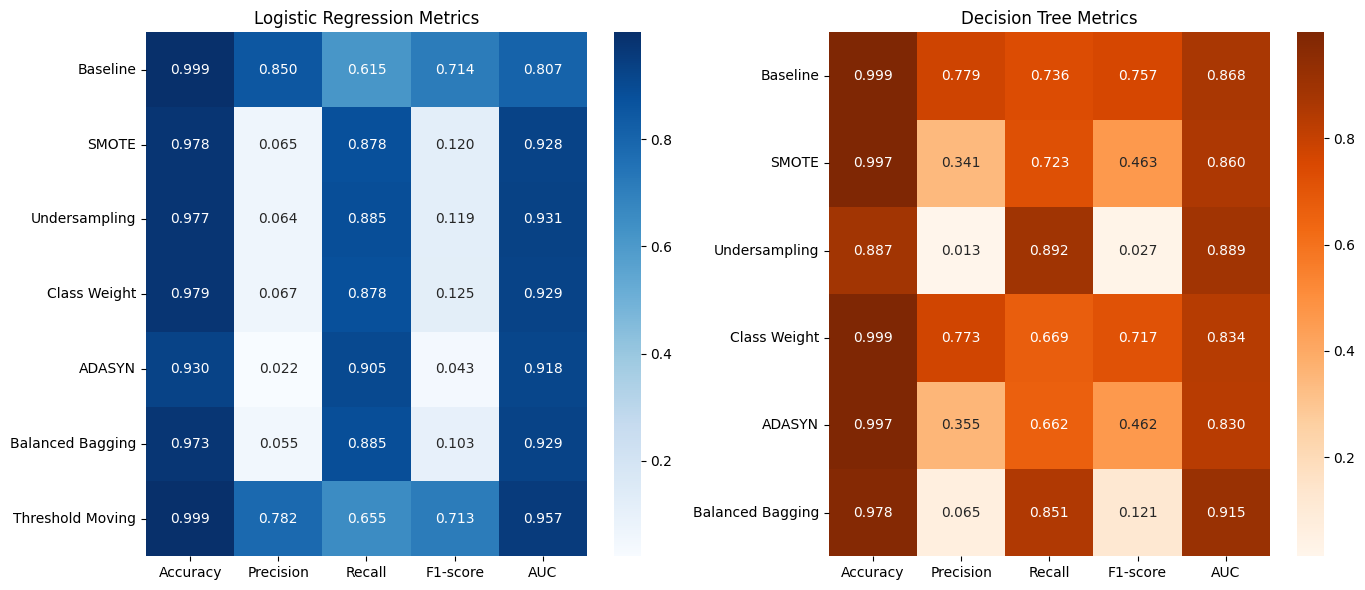

In [17]:
# Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(lr_table, annot=True, cmap="Blues", fmt=".3f", ax=axes[0])
axes[0].set_title("Logistic Regression Metrics")
sns.heatmap(dt_table, annot=True, cmap="Oranges", fmt=".3f", ax=axes[1])
axes[1].set_title("Decision Tree Metrics")
plt.tight_layout()
plt.show()

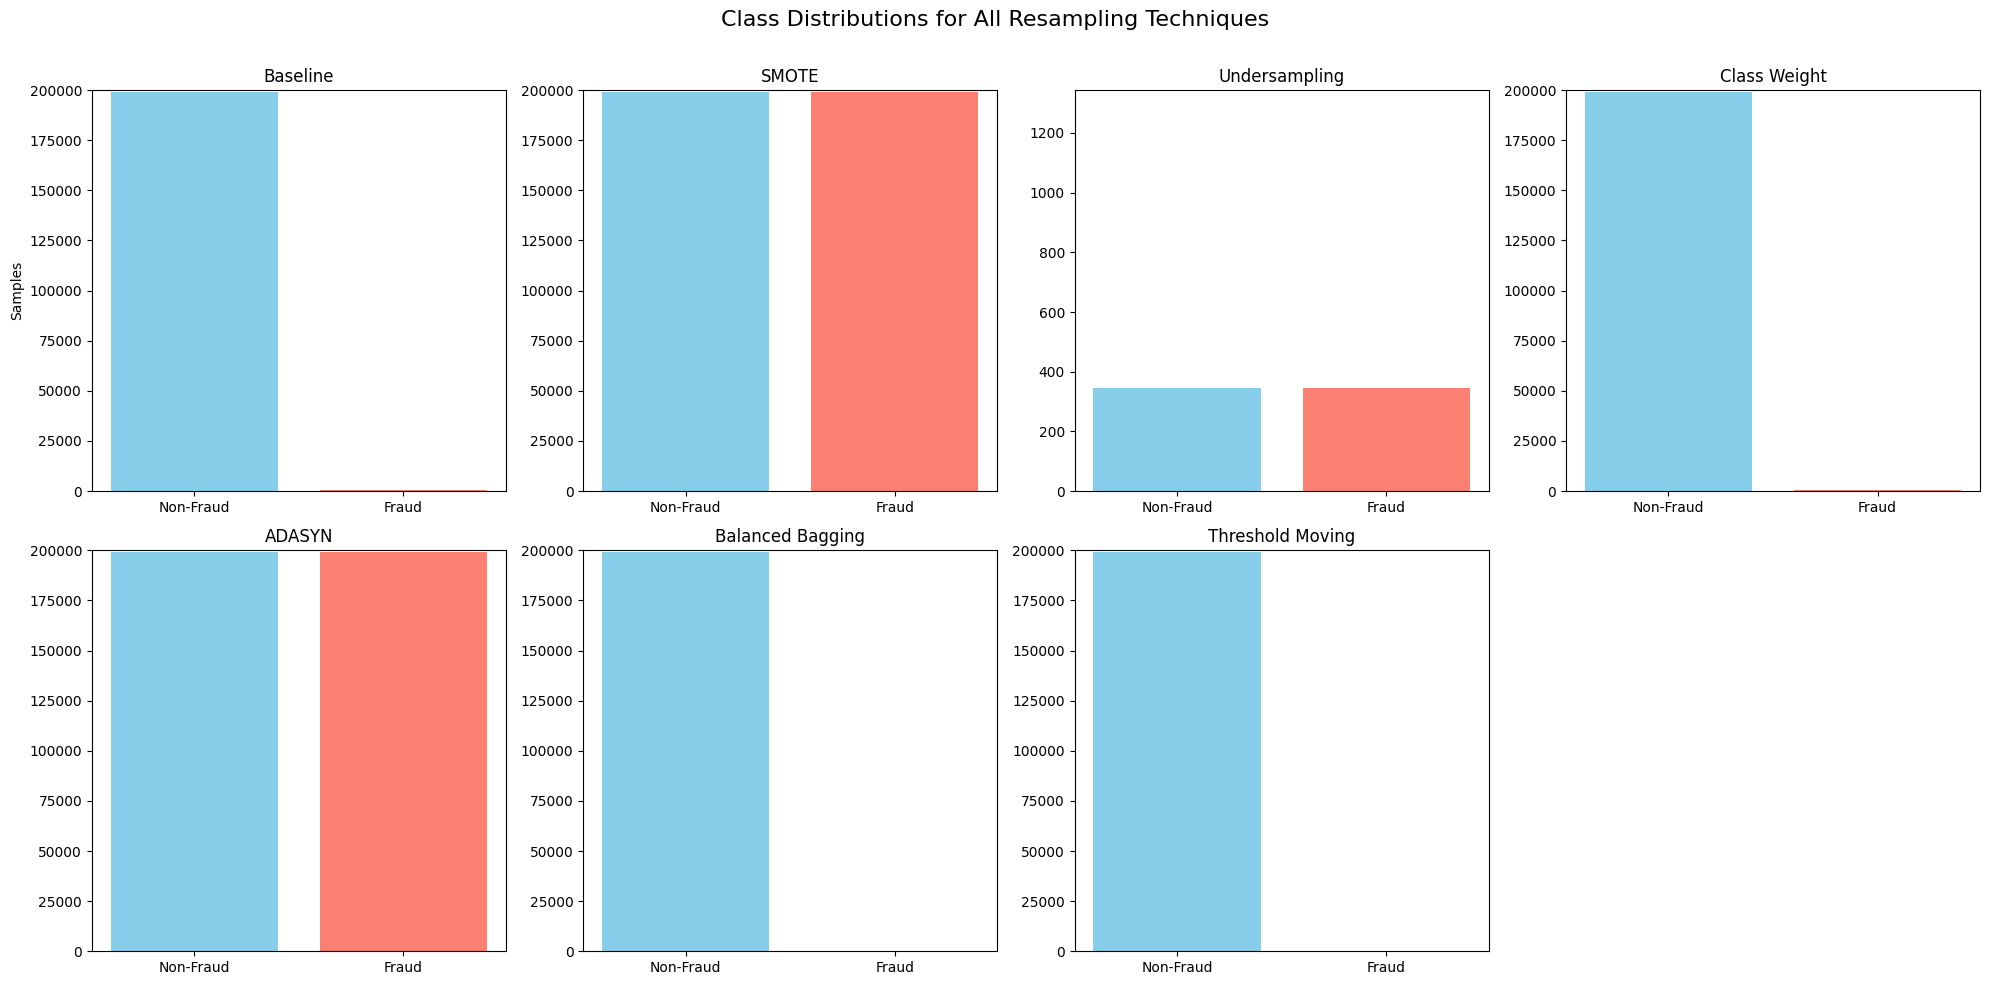

In [18]:
# Class Distributions (fixed for 2x4 grid layout)
cols = len(distributions)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust figure size for better layout

for ax, (method, dist) in zip(axes.flatten(), distributions.items()):
    ax.bar(['Non-Fraud', 'Fraud'], dist, color=['skyblue', 'salmon'])
    ax.set_title(method)
    ax.set_ylim(0, dist.max() + 1000)
    ax.set_ylabel('Samples' if method == 'Baseline' else '')

# Hide unused subplot if fewer than 8 methods
for i in range(len(distributions), 8):
    fig.delaxes(axes.flatten()[i])

fig.suptitle('Class Distributions for All Resampling Techniques', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

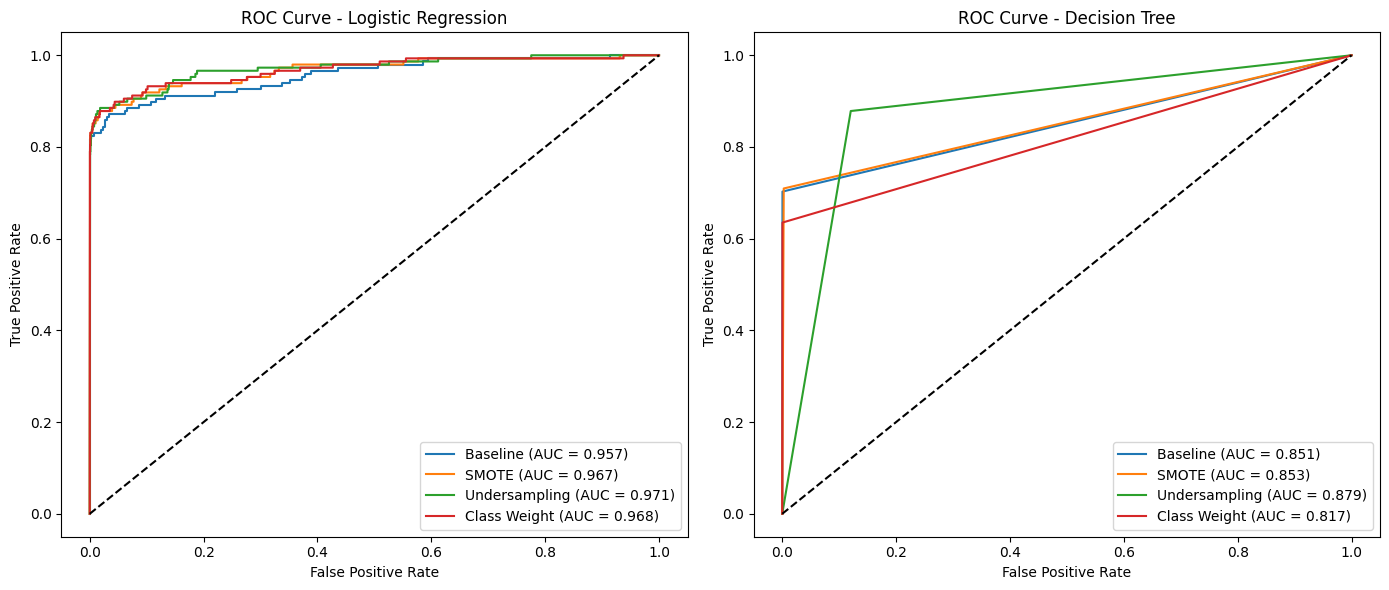

In [19]:
# === ROC CURVE VISUALIZATION ===
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# ROC for Logistic Regression
for method in ['Baseline', 'SMOTE', 'Undersampling', 'Class Weight']:
    if method == 'SMOTE':
        X_temp, y_temp = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)
        model = LogisticRegression()
    elif method == 'Undersampling':
        X_temp, y_temp = RandomUnderSampler(random_state=42).fit_resample(X_train_scaled, y_train)
        model = LogisticRegression()
    elif method == 'Class Weight':
        X_temp, y_temp = X_train_scaled, y_train
        model = LogisticRegression(class_weight='balanced')
    else:
        X_temp, y_temp = X_train_scaled, y_train
        model = LogisticRegression()

    model.fit(X_temp, y_temp)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax[0].plot(fpr, tpr, label=f'{method} (AUC = {auc(fpr, tpr):.3f})')

ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].set_title('ROC Curve - Logistic Regression')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend()

# ROC for Decision Tree
for method in ['Baseline', 'SMOTE', 'Undersampling', 'Class Weight']:
    if method == 'SMOTE':
        X_temp, y_temp = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)
        model = DecisionTreeClassifier()
    elif method == 'Undersampling':
        X_temp, y_temp = RandomUnderSampler(random_state=42).fit_resample(X_train_scaled, y_train)
        model = DecisionTreeClassifier()
    elif method == 'Class Weight':
        X_temp, y_temp = X_train_scaled, y_train
        model = DecisionTreeClassifier(class_weight='balanced')
    else:
        X_temp, y_temp = X_train_scaled, y_train
        model = DecisionTreeClassifier()

    model.fit(X_temp, y_temp)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax[1].plot(fpr, tpr, label=f'{method} (AUC = {auc(fpr, tpr):.3f})')

ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].set_title('ROC Curve - Decision Tree')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()

plt.tight_layout()
plt.show()